In [1]:
%matplotlib inline

# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from pandas.tseries.offsets import DateOffset
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

pd.options.display.float_format = '{:,.2f}'.format

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 20)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()

import PortfolioAnalyser as pa

In [2]:
import pandas as pd 
import pandas_datareader.data as web
import datetime
%matplotlib inline

In [3]:
def returns(prices):
    """
    Calculates the growth of 1 dollar invested in a stock with given prices
    """
    return (1 + prices.pct_change(1)).cumprod()

def drawdown(prices):
    """
    Calulates the drawdown of a stock with given prices
    """
    rets = returns(prices)
    return (rets.div(rets.cummax()) - 1) * 100

def cagr(prices):
    """
    Calculates the Compound Annual Growth Rate (CAGR) of a stock with given prices
    """
    delta = (prices.index[-1] - prices.index[0]).days / 365.25
    return ((prices[-1] / prices[0]) ** (1 / delta) - 1) * 100

CAGRs
SPY: 14.61%
UPRO: 32.21%


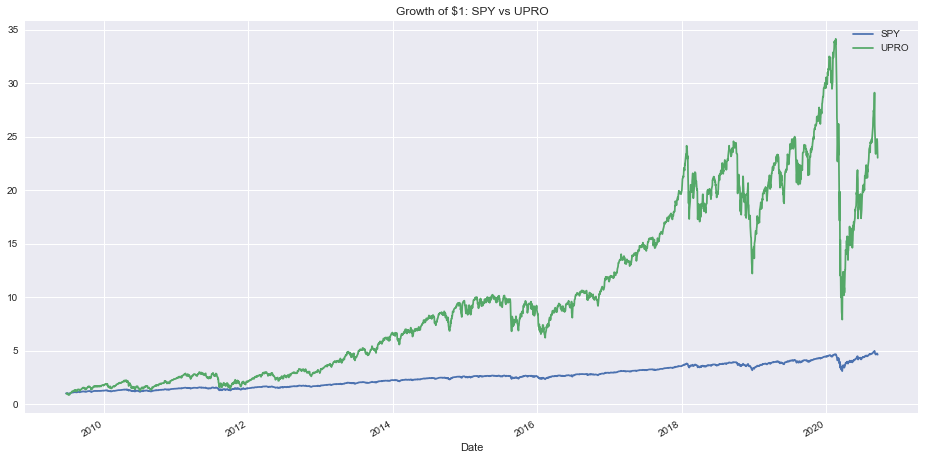

In [4]:
start = datetime.datetime(2009, 6, 23)
end = datetime.datetime(2030, 1, 1)

spy = web.DataReader("SPY", "yahoo", start, end)["Adj Close"]
upro = web.DataReader("UPRO", "yahoo", start, end)["Adj Close"]

spy_returns = returns(spy).rename("SPY")
upro_returns = returns(upro).rename("UPRO")

spy_returns.plot(title="Growth of $1: SPY vs UPRO", legend=True, figsize=(16,8))
upro_returns.plot(legend=True)

print("CAGRs")
print(f"SPY: {cagr(spy):.2f}%")
print(f"UPRO: {cagr(upro):.2f}%")

Max Drawdown
SPY: 2020-03-23 00:00:00 -33.72%
UPRO: 2020-03-23 00:00:00 -76.82%


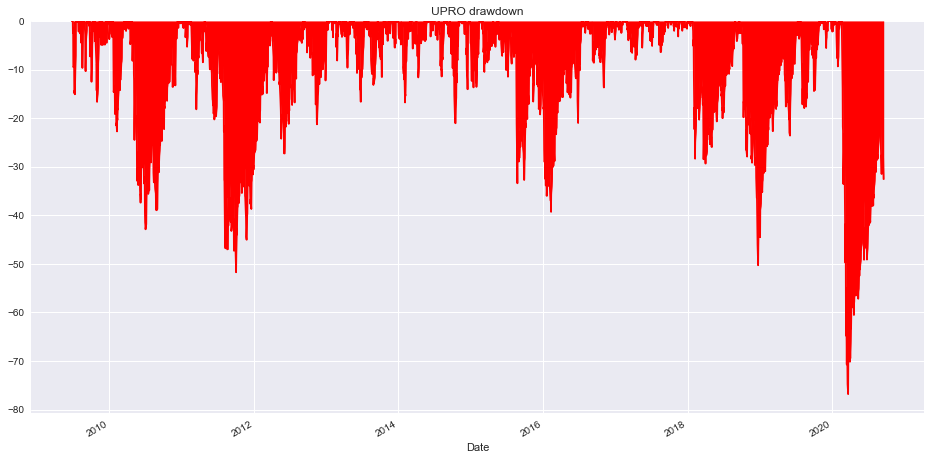

In [5]:
spy_drawdown = drawdown(spy)
upro_drawdown = drawdown(upro)
print("Max Drawdown")
print(f"SPY: {spy_drawdown.idxmin()} {spy_drawdown.min():.2f}%")
print(f"UPRO: {upro_drawdown.idxmin()} {upro_drawdown.min():.2f}%")
upro_drawdown.plot.area(color="red", title="UPRO drawdown", figsize=(16,8));

In [6]:
def sim_leverage(proxy, leverage=1, expense_ratio = 0.0, initial_value=1.0):
    pct_change = proxy.pct_change(1)
    pct_change = (pct_change - expense_ratio / 252) * leverage
    sim = (1 + pct_change).cumprod() * initial_value
    sim[0] = initial_value
    return sim

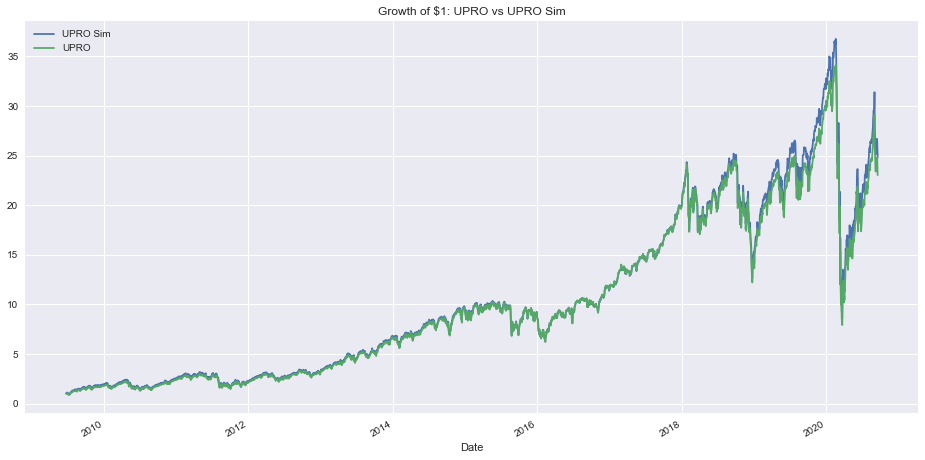

In [7]:
vfinx = web.DataReader("VFINX", "yahoo", start, end)["Adj Close"]
upro_sim = sim_leverage(vfinx, leverage=3.0, expense_ratio=0.0092).rename("UPRO Sim")
upro_sim.plot(title="Growth of $1: UPRO vs UPRO Sim", legend=True, figsize=(16,8))
upro_returns.plot(legend=True);

CAGRs
VFINX: 10.77%
UPRO Sim: 19.31%


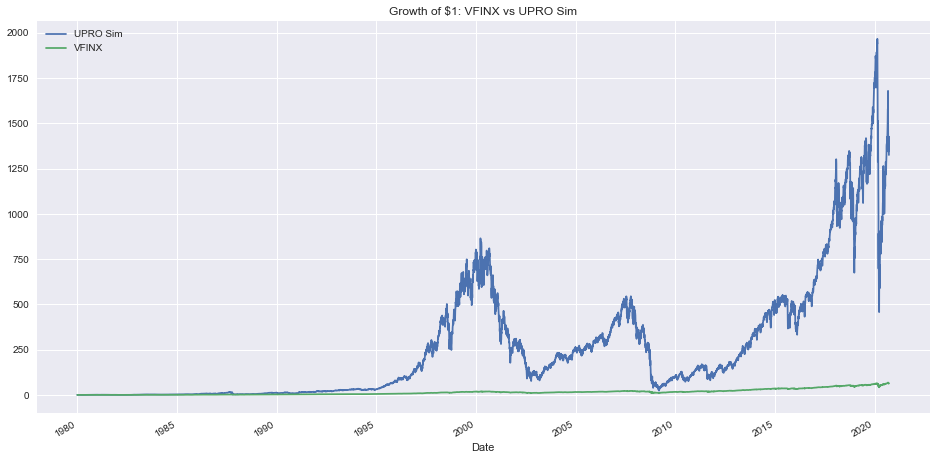

In [8]:
start = datetime.datetime(1976, 8, 31)
vfinx = web.DataReader("VFINX", "yahoo", start, end)["Adj Close"]
upro_sim = sim_leverage(vfinx, leverage=3.0, expense_ratio=0.0092).rename("UPRO Sim")
upro_sim.plot(title="Growth of $1: VFINX vs UPRO Sim", legend=True, figsize=(16,8))

vfinx_returns = returns(vfinx).rename("VFINX")
vfinx_returns.plot(legend=True)

print("CAGRs")
print(f"VFINX: {cagr(vfinx):.2f}%")
print(f"UPRO Sim: {cagr(upro_sim):.2f}%")

Max Drawdown
UPRO: 2009-03-09 00:00:00 -97.11%


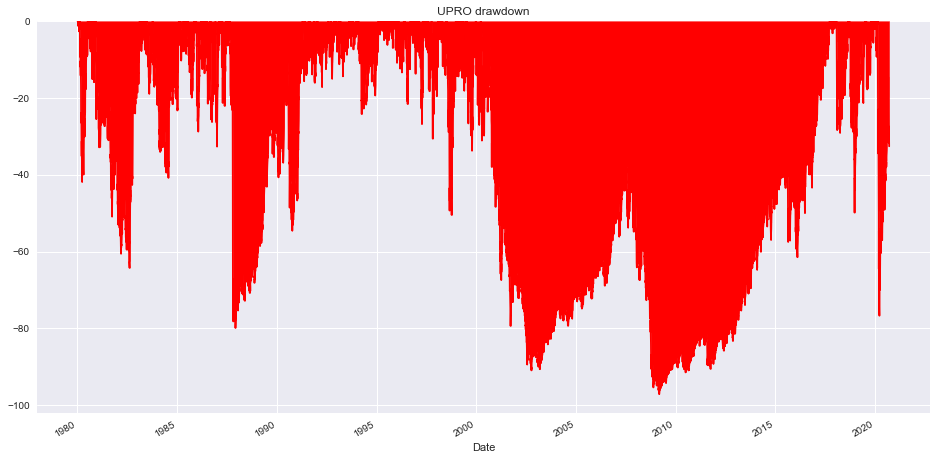

In [9]:
spy_drawdown = drawdown(spy)
upro_drawdown = drawdown(upro_sim)
print("Max Drawdown")
print(f"UPRO: {upro_drawdown.idxmin()} {upro_drawdown.min():.2f}%")
upro_drawdown.plot.area(color="red", title="UPRO drawdown", figsize=(16,8));

In [10]:
def sim_leverage(proxy, leverage=1, expense_ratio = 0.0, initial_value=1.0):
    pct_change = proxy.pct_change(1)
    pct_change = (pct_change - expense_ratio / 252) * leverage
    sim = (1 + pct_change).cumprod() * initial_value
    sim[0] = initial_value
    return sim

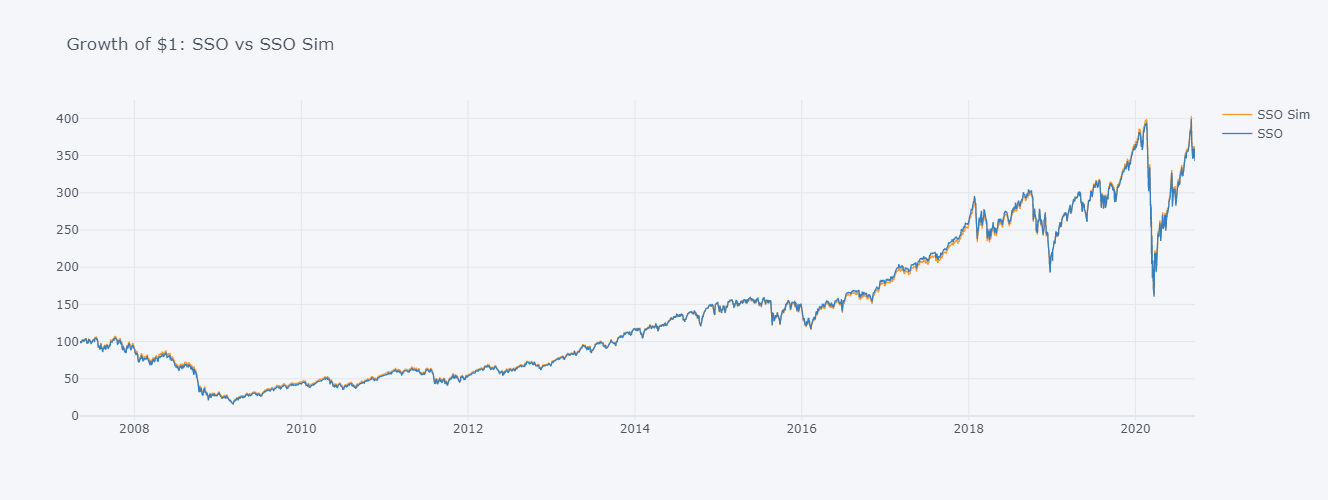

CAGRs
SSO: 9.66%
SSO Sim: 9.74%


In [11]:
start='2007-05-05'

SSO = web.DataReader("SSO", "yahoo", start, end)["Adj Close"]
SSO_returns = returns(SSO).rename("SSO")

vfinx = web.DataReader("VFINX", "yahoo", start, end)["Adj Close"]
SSO_sim = sim_leverage(vfinx, leverage=2, expense_ratio=0.01).rename("SSO Sim")
SSO_VFINX = (pa.merge_time_series(pd.DataFrame(SSO_sim), pd.DataFrame(SSO_returns)) * 100).dropna()
SSO_VFINX.iplot(title="Growth of $1: SSO vs SSO Sim", dimensions=pa.dimensions)
print("CAGRs")
print(f"SSO: {cagr(SSO_VFINX['SSO']):.2f}%")
print(f"SSO Sim: {cagr(SSO_VFINX['SSO Sim']):.2f}%")

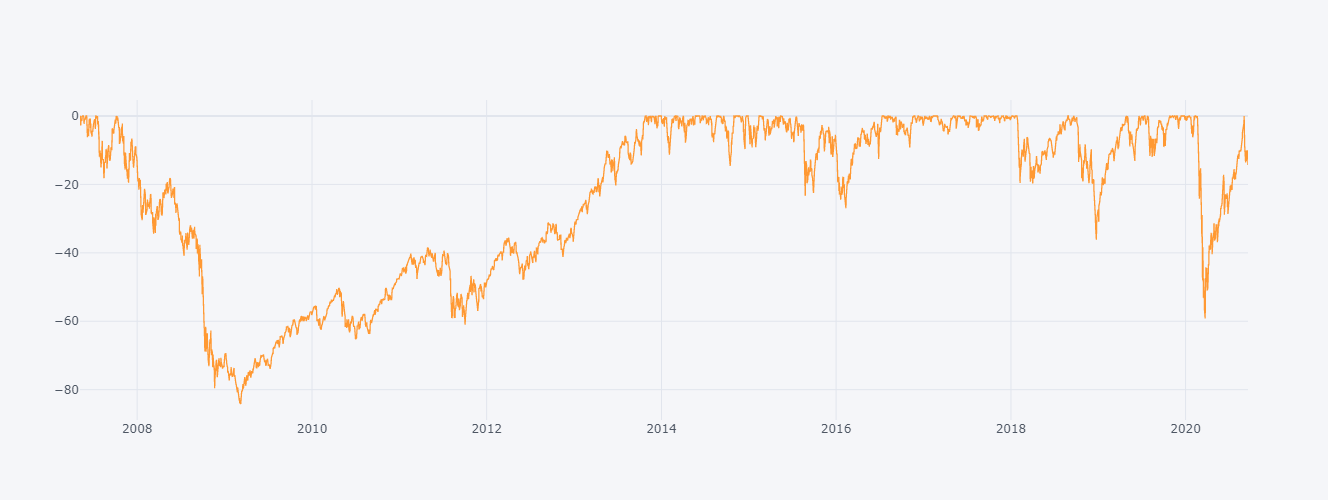

In [12]:
pa.compute_drawdowns(SSO_sim).iplot(dimensions=pa.dimensions)

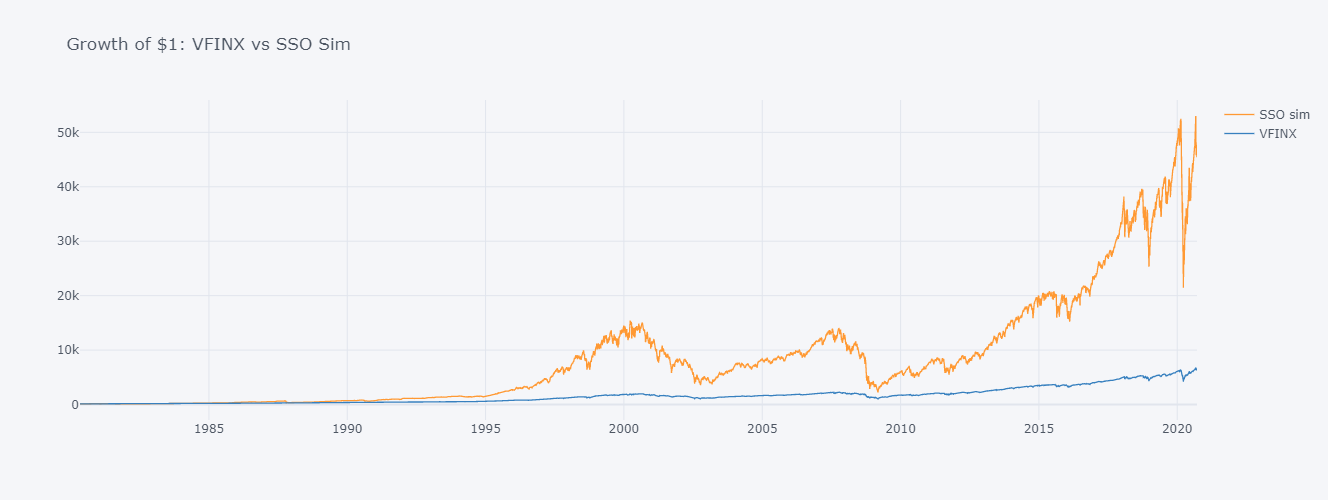

CAGRs
VFINX: 10.80%
SSO Sim: 16.36%


In [13]:
start='1980-05-05'

vfinx = web.DataReader("VFINX", "yahoo", start, end)["Adj Close"]
SSO_sim = sim_leverage(vfinx, leverage=2.0, expense_ratio=0.01).rename("SSO Sim")
SSO_VFINX = pa.compute_growth_index((pa.merge_time_series(pd.DataFrame(SSO_sim), pd.DataFrame(vfinx)) * 100).dropna())
SSO_VFINX.columns = ['SSO sim', 'VFINX']
SSO_VFINX.iplot(title="Growth of $1: VFINX vs SSO Sim", dimensions=pa.dimensions)
print("CAGRs")
print(f"VFINX: {cagr(SSO_VFINX['VFINX']):.2f}%")
print(f"SSO Sim: {cagr(SSO_VFINX['SSO sim']):.2f}%")

In [14]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF